In [1]:
# Import the required libraries
from numpy import zeros, ones
from numpy.random import randn, randint

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.utils import plot_model

from matplotlib import pyplot as plt

In [2]:
def define_discriminator(in_shape=(128,128,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(128, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 64x64
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 32x32
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 16x16
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 8x8
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       1

C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None


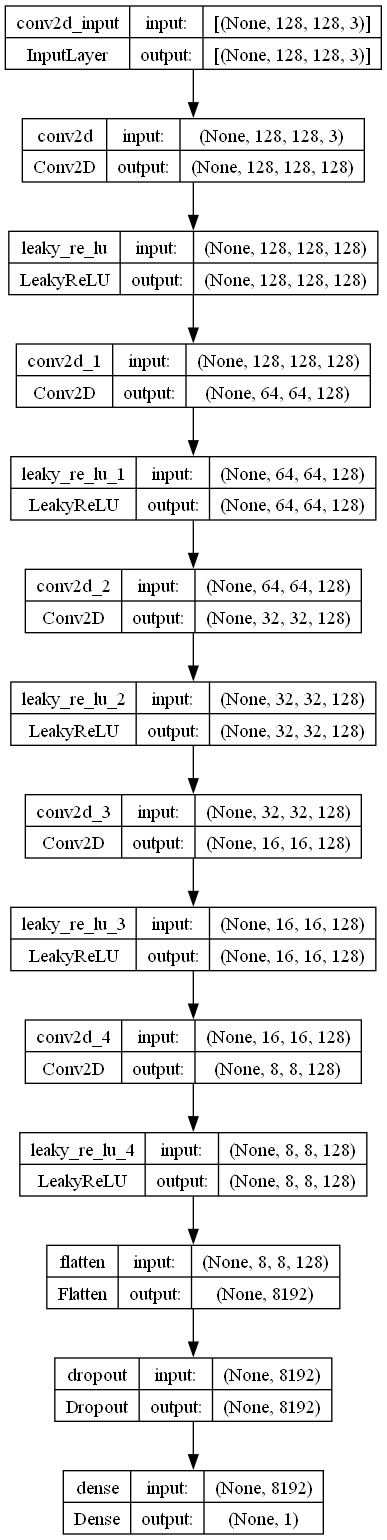

In [3]:
#Verify the model summary
test_discr = define_discriminator()
print(test_discr.summary())
plot_model(test_discr, to_file='disc_model.png', show_shapes=True)


In [4]:
def define_generator(latent_dim):
	model = Sequential()
	# Define number of nodes that can be gradually reshaped and upscaled to 128x128x3
	n_nodes = 128 * 8 * 8 #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 64x64
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 128x128
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer 128x128x3
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #tanh goes from [-1,1]
	return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

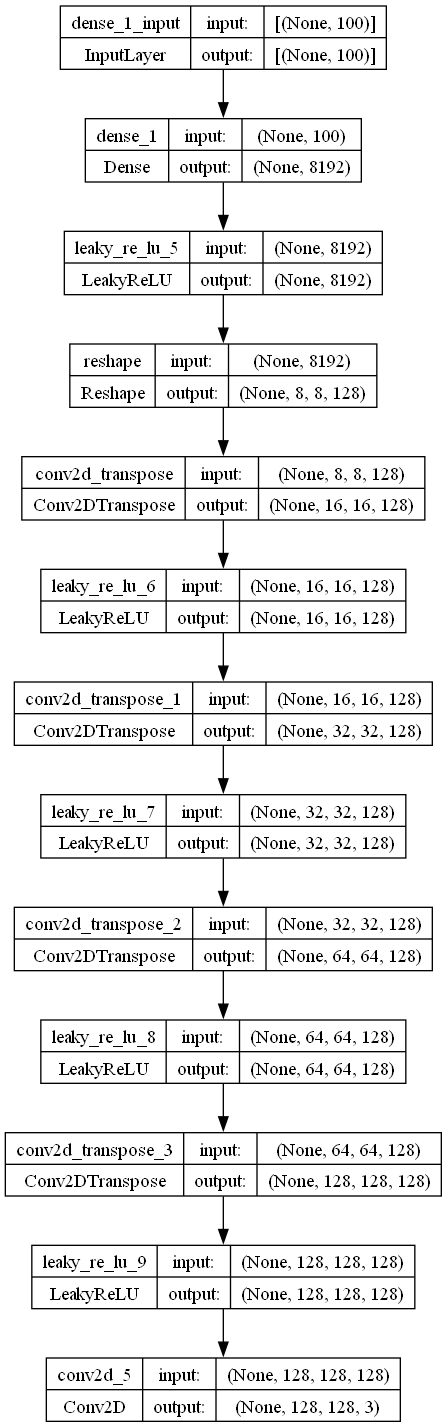

In [5]:
test_gen = define_generator(100)
print(test_gen.summary())
plot_model(test_gen, to_file='generator_model.png', show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       1901059   
                                                                 
 sequential (Sequential)     (None, 1)                 602113    
                                                                 
Total params: 2,503,172
Trainable params: 1,901,059
Non-trainable params: 602,113
_________________________________________________________________
None


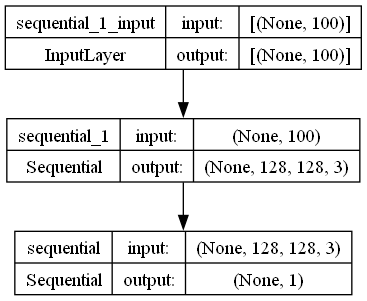

In [6]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

test_gan = define_gan(test_gen, test_discr)
print(test_gan.summary())
plot_model(test_gan, to_file='combined_model.png', show_shapes=True)

In [13]:
def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, 1)) # Class labels for real images are 1
	return X, y

# Function to generate random latent points
def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim) #Reshape to be provided as input to the generator. 
	return x_input

# Function to generate fake images using latent vectors
def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples) #Generate latent points as input to the generator
	X = g_model.predict(x_input) #Use the generator to generate fake images
	y = zeros((n_samples, 1)) # Class labels for fake images are 0
	return X, y

# Function to save Plots after every n number of epochs
def save_plot(examples, epoch, n=10):
	# scale images from [-1,1] to [0,1] so we can plot
	examples = (examples + 1) / 2.0
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i])
	# save plot to a file so we can view how generated images evolved over epochs
	filename = 'saved_data_during_training/images/generated_plot_128x128_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

In [14]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# Fetch real images
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real images - get accuracy
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# Generate fake images
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake images - get accuracy
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# Print discriminate accuracies on ral and fake images. 
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save generated images periodically using the save_plot function
	save_plot(x_fake, epoch)
	# save the generator model
	filename = 'saved_data_during_training/models/generator_model_128x128_%03d.h5' % (epoch+1)
	g_model.save(filename)


In [15]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2) #Disc. trained on half batch real and half batch fake images
	#  enumerate epochs
	for i in range(n_epochs):
		# enumerate batches 
		for j in range(bat_per_epo):
			# Fetch random 'real' images
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# Train the discriminator using real images
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' images 
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# Train the discriminator using fake images
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# Generate latent vectors as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# Label generated (fake) mages as 1 to fool the discriminator 
			y_gan = ones((n_batch, 1))
			# Train the generator (via the discriminator's error)
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# Report disc. and gen losses. 
			print('Epoch>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [16]:
import os
import numpy as np
import cv2
from PIL import Image
import random

n=23000 #Number of images to read from the directory. (For training)
SIZE = 128 #Resize images to this size
all_img_list = os.listdir('C:/Project/face/UTKFace') #
all_img_list
dataset_list = random.sample(all_img_list, n) #Get n random images from the directory

#Read images, resize and capture into a numpy array
dataset = []

for img in dataset_list:

    temp_img = cv2.imread('C:/Project/face/UTKFace/'+img)
    temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
     #opencv reads images as BGR so let us convert back to RGB
    temp_img = Image.fromarray(temp_img)
    temp_img = temp_img.resize((SIZE, SIZE)) #Resize
    dataset.append(np.array(temp_img))   

dataset = np.array(dataset) #Convert the list to numpy array

#Rescale to [-1, 1] - remember that the generator uses tanh activation that goes from -1,1
dataset = dataset.astype('float32')
	# scale from [0,255] to [-1,1]
dataset = (dataset - 127.5) / 127.5

# size of the latent space
latent_dim = 100
# create the discriminator using our pre-defined function
d_model = define_discriminator()
# create the generator using our pre-defined function
g_model = define_generator(latent_dim)
# create the gan  using our pre-defined function
gan_model = define_gan(g_model, d_model)


In [17]:
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100)

2/2 [==============================] - 3s 6ms/step


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_5/sequential_3/conv2d_7/Conv2D' defined at (most recent call last):
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\likhi\AppData\Local\Temp\ipykernel_24708\902966090.py", line 1, in <cell line: 1>
      train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100)
    File "C:\Users\likhi\AppData\Local\Temp\ipykernel_24708\953148709.py", line 21, in train
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2381, in train_on_batch
      logs = self.train_function(iterator)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "C:\Users\likhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_5/sequential_3/conv2d_7/Conv2D'
OOM when allocating tensor with shape[128,129,129,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_5/sequential_3/conv2d_7/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_3252]